# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [586]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
#!kaggle datasets download -d khaledzsa/traffic-dataset
#!unzip traffic-dataset.zip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,GRU,SimpleRNN,Input
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping,ModelCheckpoint
from statsmodels.tools.eval_measures import rmse


In [587]:
df=pd.read_csv('Traffic Data.csv',parse_dates=['date_time'],index_col='date_time')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [589]:
df.isnull().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
dtype: int64

In [590]:
df=df.sort_values(by='date_time')

In [591]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm


In [592]:
df.duplicated().sum()

18

In [593]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [594]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm


In [595]:
df=df.resample('M').agg({
    'traffic_volume':'mean',
    'temp':'mean',
    'rain_1h':'mean',
    'snow_1h':'mean',
    'clouds_all':'mean',
    'weather_main':lambda x: x.mode()[0],
})

C:\Users\tabt6\AppData\Local\Temp\ipykernel_41928\1001865025.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df=df.resample('M').agg({


In [596]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main
date_time,,,,,,
2016-11-30,2704.857143,274.637456,0.000000,0.0,72.440313,Mist
2016-12-31,2996.451717,266.966187,0.000000,0.0,62.292918,Snow
2017-01-31,3023.540567,267.956684,0.000000,0.0,59.460411,Mist
2017-02-28,3383.618513,271.984593,0.000000,0.0,36.468443,Clear
2017-03-31,3414.931792,273.882821,0.000000,0.0,52.494798,Clear
2017-04-30,3366.454262,282.207017,0.000000,0.0,59.879418,Clear
2017-05-31,3353.585084,286.285599,0.000000,0.0,53.825630,Clouds
2017-06-30,3461.548148,293.603193,0.000000,0.0,38.969136,Clear
2017-07-31,3237.886926,295.470495,0.000000,0.0,33.901060,Clouds


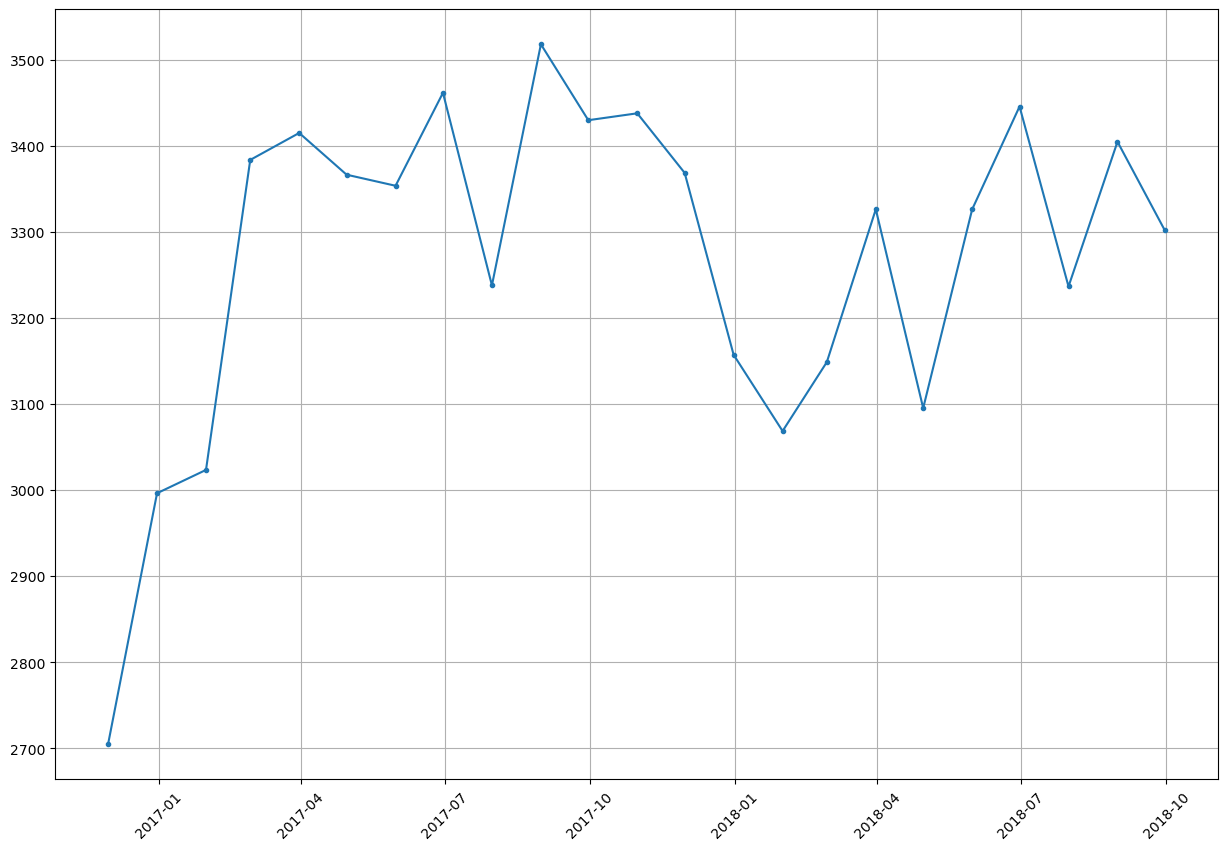

In [597]:
plt.figure(figsize=(15,10))
plt.plot(df.index,df['traffic_volume'],marker='.')
plt.xticks(rotation=45)
plt.grid(True)

In [598]:
df['Day_of_the_week']= df.index.day_of_week
df['Month'] = df.index.month
df['Day_of_the_year'] = df.index.day_of_year
monthly_average = df.groupby('Month')['traffic_volume'].mean()

([<matplotlib.axis.XTick at 0x16571dca7b0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

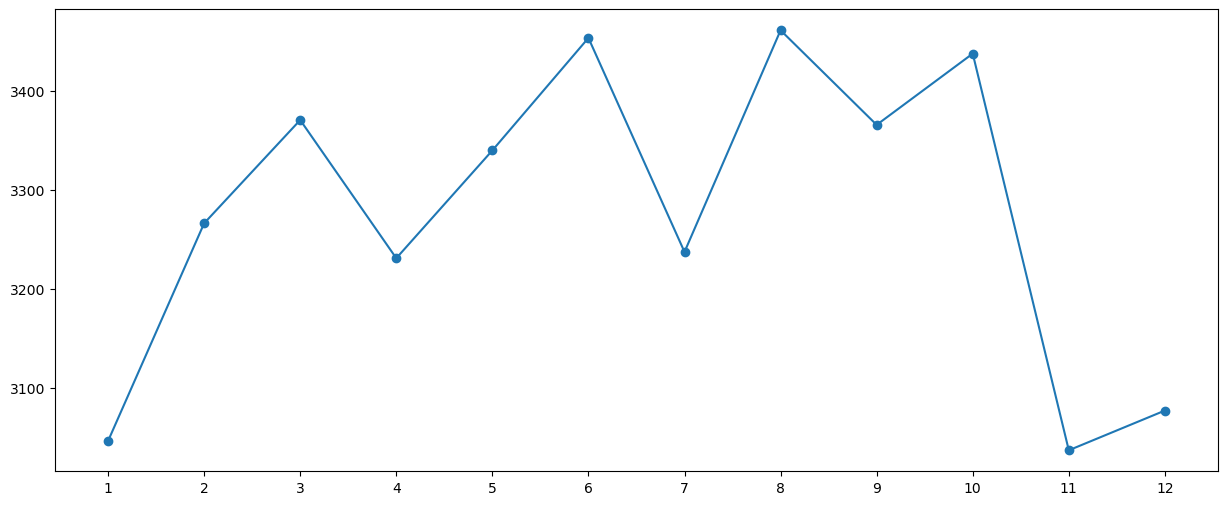

In [599]:
plt.figure(figsize=(15,6))
plt.plot(monthly_average.index,monthly_average.values,marker='o')
plt.xticks(range(1,13))

<Axes: xlabel='date_time'>

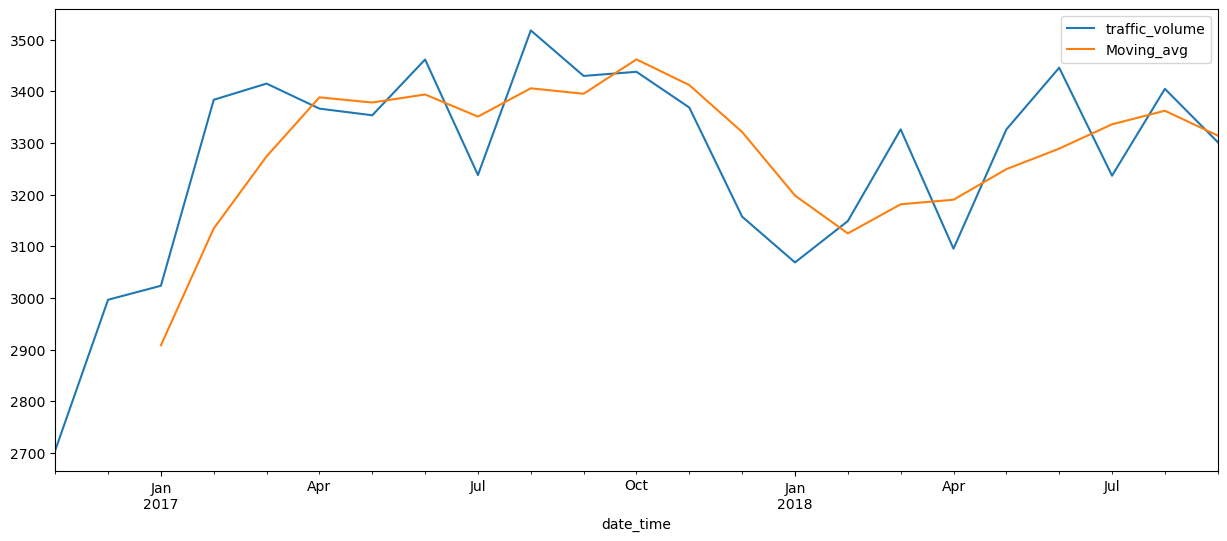

In [600]:
df['Moving_avg']=df['traffic_volume'].rolling(window=3).mean()
df[['traffic_volume','Moving_avg']].plot(figsize=(15,6))

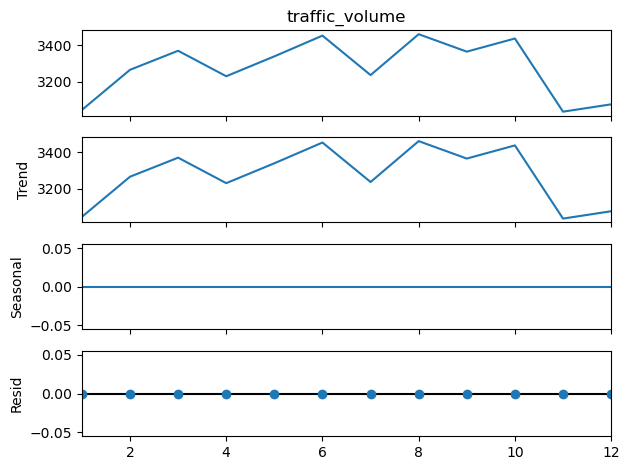

In [601]:
decomposition = seasonal_decompose(x=monthly_average, model='additive',period=1)
decomposition.plot()
plt.show()

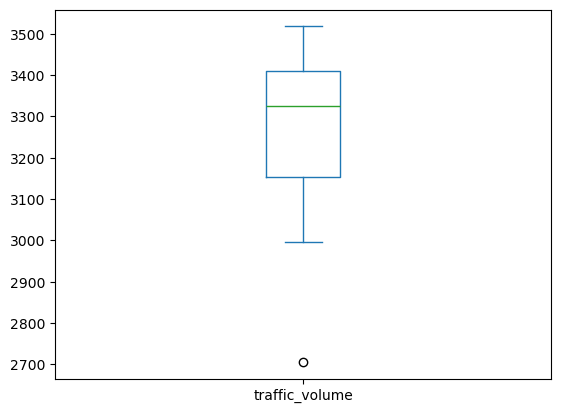

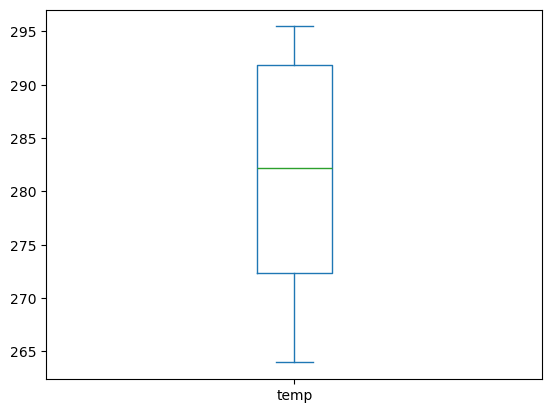

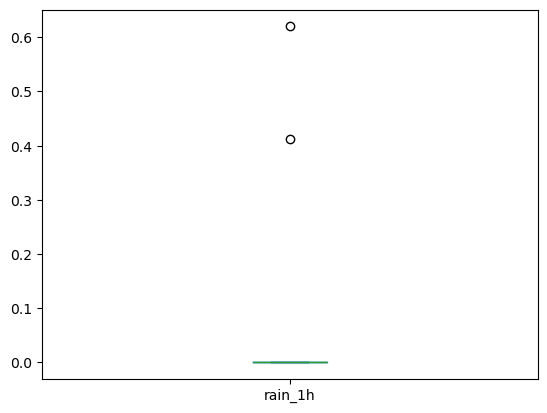

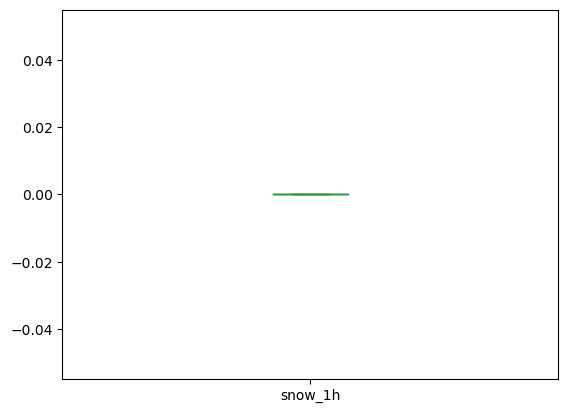

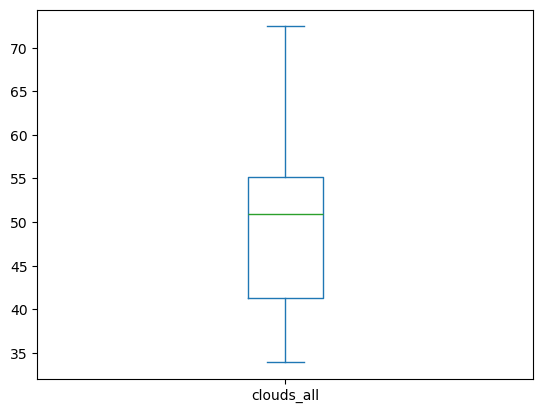

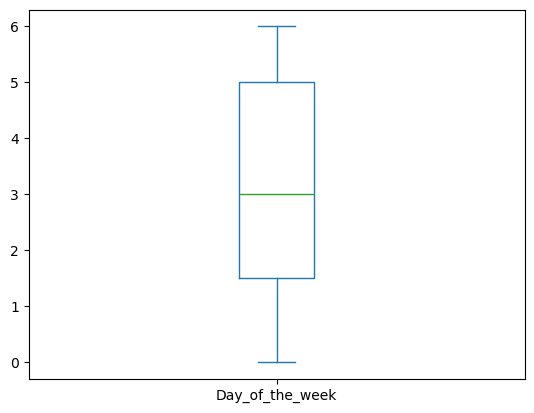

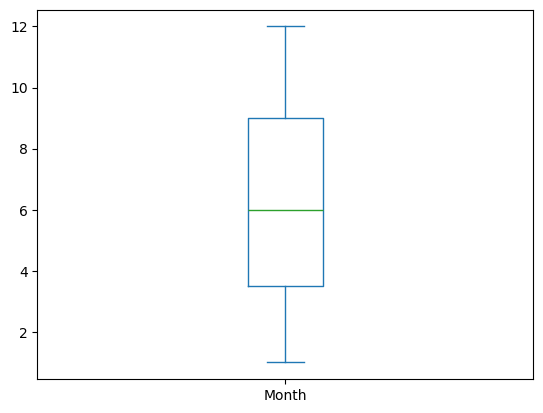

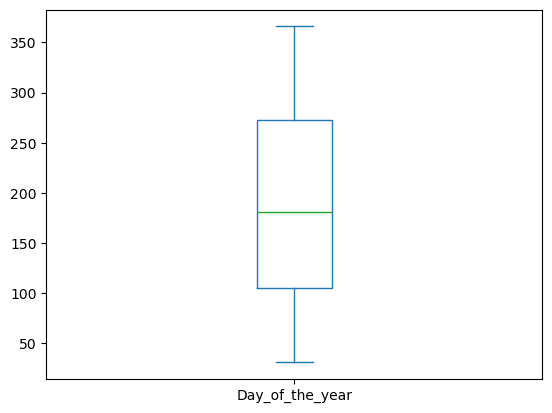

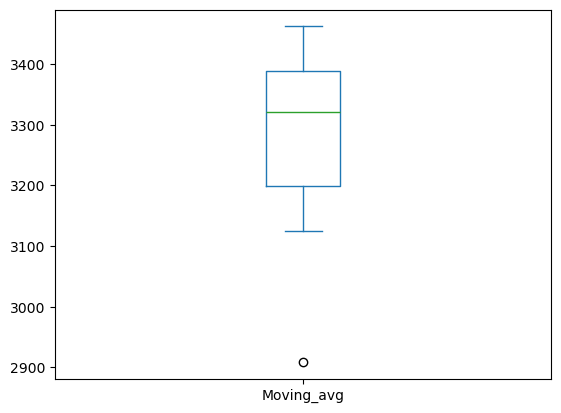

In [602]:
for i in df.select_dtypes('number'):
     df[i].plot(kind='box')
     plt.show()


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [603]:
lags=[]
for i in range(1,6):
    df[f'Lag_{i}']=df['traffic_volume'].shift(i)
    lags.append(f'Lags_{i}')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,Day_of_the_week,Month,Day_of_the_year,Moving_avg,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
date_time,,,,,,,,,,,,,,,
2016-11-30,2704.857143,274.637456,0.000000,0.0,72.440313,Mist,2,11,335,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,2996.451717,266.966187,0.000000,0.0,62.292918,Snow,5,12,366,NaN,2704.857143,NaN,NaN,NaN,NaN
2017-01-31,3023.540567,267.956684,0.000000,0.0,59.460411,Mist,1,1,31,2908.283142,2996.451717,2704.857143,NaN,NaN,NaN
2017-02-28,3383.618513,271.984593,0.000000,0.0,36.468443,Clear,1,2,59,3134.536932,3023.540567,2996.451717,2704.857143,NaN,NaN
2017-03-31,3414.931792,273.882821,0.000000,0.0,52.494798,Clear,4,3,90,3274.030291,3383.618513,3023.540567,2996.451717,2704.857143,NaN
2017-04-30,3366.454262,282.207017,0.000000,0.0,59.879418,Clear,6,4,120,3388.334856,3414.931792,3383.618513,3023.540567,2996.451717,2704.857143
2017-05-31,3353.585084,286.285599,0.000000,0.0,53.825630,Clouds,2,5,151,3378.323713,3366.454262,3414.931792,3383.618513,3023.540567,2996.451717
2017-06-30,3461.548148,293.603193,0.000000,0.0,38.969136,Clear,4,6,181,3393.862498,3353.585084,3366.454262,3414.931792,3383.618513,3023.540567
2017-07-31,3237.886926,295.470495,0.000000,0.0,33.901060,Clouds,0,7,212,3351.006719,3461.548148,3353.585084,3366.454262,3414.931792,3383.618513


In [604]:
df['Difference between traffic_volume']=df['Day_of_the_week'].diff()

In [605]:
df.dropna(inplace=True)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [606]:
X=df.drop(columns=['traffic_volume'])
y=df['traffic_volume']

In [607]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)

In [608]:
X_train.describe()

,temp,rain_1h,snow_1h,clouds_all,Day_of_the_week,Month,Day_of_the_year,Moving_avg,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Difference between traffic_volume
count,14.000000,14.0,14.0,14.000000,14.00,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,280.897914,0.0,0.0,48.087485,3.00,6.214286,188.142857,3317.947633,3313.197089,3333.789416,3312.164916,3301.284157,3275.296411,-0.071429
std,11.313609,0.0,0.0,7.934756,2.00,3.400873,103.721415,107.434878,145.537252,132.115601,156.047394,172.734511,228.717453,3.292516
min,263.955236,0.0,0.0,33.901060,0.00,1.000000,31.000000,3124.910520,3068.685585,3068.685585,3023.540567,2996.451717,2704.857143,-5.000000
25%,273.149289,0.0,0.0,40.856032,2.00,4.000000,120.000000,3210.942713,3177.419459,3259.986086,3177.419459,3177.419459,3177.419459,-4.000000
50%,282.676694,0.0,0.0,49.358819,3.00,5.500000,166.000000,3364.665216,3360.019673,3367.509351,3367.509351,3367.509351,3367.509351,2.000000
75%,291.675845,0.0,0.0,53.286287,4.75,8.750000,265.500000,3394.859853,3426.047314,3426.047314,3426.047314,3426.047314,3426.047314,2.750000
max,295.470495,0.0,0.0,59.879418,6.00,12.000000,365.000000,3461.815844,3517.937500,3517.937500,3517.937500,3517.937500,3517.937500,3.000000


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [609]:
dummitrain=pd.get_dummies(X_train['weather_main'],drop_first=True)
dummitest=pd.get_dummies(X_test['weather_main'],drop_first=True)
dummitrain.astype(int)
dummitest.astype(int)

,Clouds,Rain
date_time,,
2018-06-30,1,0
2018-07-31,0,0
2018-08-31,0,1
2018-09-30,0,1


In [610]:
Columns_train=dummitrain.columns.values.tolist()
Columns_test=dummitest.columns.values.tolist()

In [611]:
dummitrain.set_index(X_train.index,inplace=True)
dummitest.set_index(X_test.index,inplace=True)
X_train[Columns_train]=dummitrain[Columns_train]
X_test[Columns_test]=dummitest[Columns_test]

In [612]:
X_train

,temp,rain_1h,snow_1h,clouds_all,weather_main,Day_of_the_week,Month,Day_of_the_year,Moving_avg,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Difference between traffic_volume,Clouds
date_time,,,,,,,,,,,,,,,,
2017-04-30,282.207017,0.0,0.0,59.879418,Clear,6,4,120,3388.334856,3414.931792,3383.618513,3023.540567,2996.451717,2704.857143,2.0,False
2017-05-31,286.285599,0.0,0.0,53.825630,Clouds,2,5,151,3378.323713,3366.454262,3414.931792,3383.618513,3023.540567,2996.451717,-4.0,True
2017-06-30,293.603193,0.0,0.0,38.969136,Clear,4,6,181,3393.862498,3353.585084,3366.454262,3414.931792,3383.618513,3023.540567,2.0,False
2017-07-31,295.470495,0.0,0.0,33.901060,Clouds,0,7,212,3351.006719,3461.548148,3353.585084,3366.454262,3414.931792,3383.618513,-4.0,True
2017-08-31,291.800194,0.0,0.0,50.655208,Clouds,3,8,243,3405.790858,3237.886926,3461.548148,3353.585084,3366.454262,3414.931792,3.0,True
2017-09-30,291.302799,0.0,0.0,40.374378,Clouds,5,9,273,3395.192304,3517.937500,3237.886926,3461.548148,3353.585084,3366.454262,2.0,True
2017-10-31,283.146371,0.0,0.0,56.593750,Clouds,1,10,304,3461.815844,3429.752488,3517.937500,3237.886926,3461.548148,3353.585084,-4.0,True
2017-11-30,274.231289,0.0,0.0,51.668258,Clear,3,11,334,3412.024823,3437.757543,3429.752488,3517.937500,3237.886926,3461.548148,2.0,False
2017-12-31,266.348409,0.0,0.0,58.063636,Clouds,6,12,365,3321.195206,3368.564439,3437.757543,3429.752488,3517.937500,3237.886926,3.0,True


In [613]:
column_num=['temp','rain_1h','snow_1h','clouds_all','Lag_1','Lag_2','Lag_3','Lag_4','Lag_5']


In [614]:
scaler=MinMaxScaler()
scaler.fit(X_train[column_num])

MinMaxScaler()

In [615]:
X_train=scaler.transform(X_train[column_num])
X_test=scaler.transform(X_test[column_num])

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [616]:
modelGRU=Sequential([
    GRU(units=70,return_sequences=True,input_shape=(X_train.shape[1],1)),
    GRU(units=60,return_sequences=False),
    Dense(units=15),
    Dense(units=1)
])
modelGRU.summary()

c:\Users\tabt6\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                    │ (None, 9, 70)          │        15,330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 60)             │        23,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │           915 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,021 (156.33 KB)

 Trainable params: 40,021 (156.33 KB)

 Non-trainable params: 0 (0.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [617]:
modelGRU.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])

In [618]:
Early_Stopping=EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True)
Check_point=ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [619]:
History_GRU=modelGRU.fit(X_train,y_train,epochs=1000,validation_split=0.2,callbacks=[Early_Stopping,Check_point])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 11058941.0000 - mean_squared_error: 11058941.0000 - val_loss: 10569005.0000 - val_mean_squared_error: 10569005.0000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 11058367.0000 - mean_squared_error: 11058367.0000 - val_loss: 10568604.0000 - val_mean_squared_error: 10568604.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 11057791.0000 - mean_squared_error: 11057791.0000 - val_loss: 10568193.0000 - val_mean_squared_error: 10568193.0000
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 11057203.0000 - mean_squared_error: 11057203.0000 - val_loss: 10567767.0000 - val_mean_squared_error: 10567767.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 11056592.0000 - mean_squared_error: 11056592.0000 - val_loss: 10567313.0000 - val_mean_squared_error: 10567313.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 11055944.0000 - mean_squared_error: 11055944.0000 - val_loss:

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [620]:
his_GRU=pd.DataFrame(History_GRU.history)
his_GRU

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,11058941.00,11058941.00,1.056900e+07,1.056900e+07
1,11058367.00,11058367.00,1.056860e+07,1.056860e+07
2,11057791.00,11057791.00,1.056819e+07,1.056819e+07
3,11057203.00,11057203.00,1.056777e+07,1.056777e+07
4,11056592.00,11056592.00,1.056731e+07,1.056731e+07
...,...,...,...,...
995,2064789.50,2064789.50,1.845463e+06,1.845463e+06
996,2057196.75,2057196.75,1.838277e+06,1.838277e+06
997,2049621.50,2049621.50,1.831108e+06,1.831108e+06
998,2042062.75,2042062.75,1.823956e+06,1.823956e+06


<Axes: >

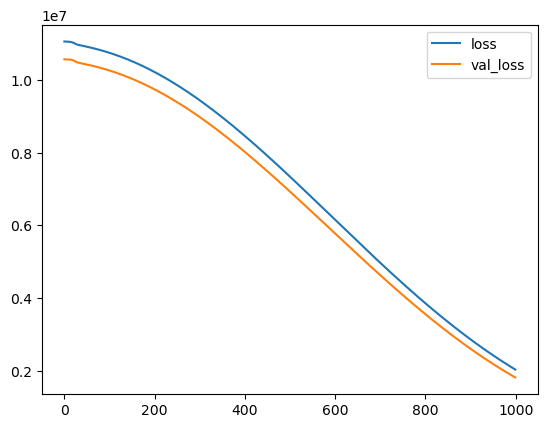

In [621]:
his_GRU[['loss','val_loss']].plot()

In [622]:
y_pred = modelGRU.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

<Axes: >

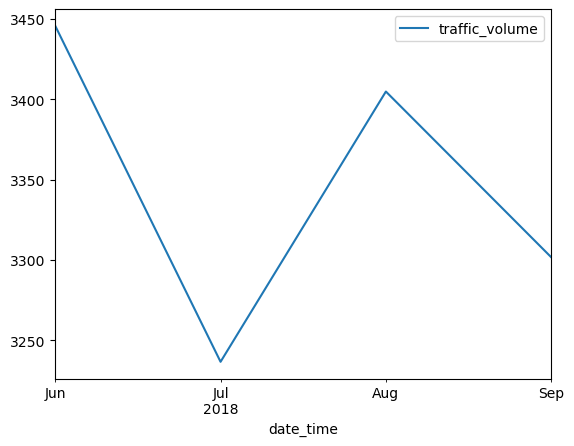

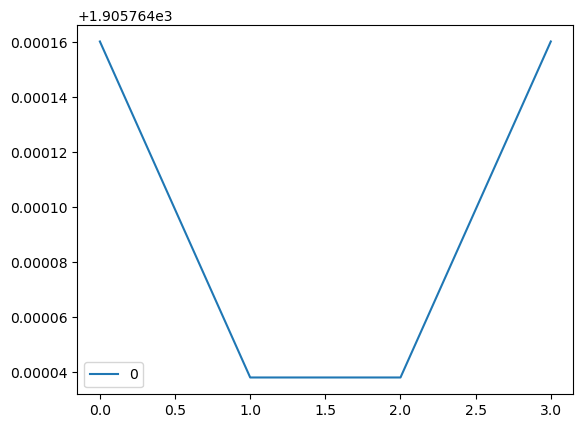

In [623]:
pd.DataFrame(y_test).plot()
pd.DataFrame(y_pred).plot()

In [624]:
print(mean_squared_error(y_pred,y_test))
print(rmse(y_pred,y_test))

2084463.219220649
[1539.88194899 1330.83960887 1498.98378223 1395.89757111]


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [637]:
modelRNN=Sequential([
    Input(shape=(X_train.shape[1],1)),
    SimpleRNN(50,return_sequences=True,recurrent_dropout=0.15),
    SimpleRNN(50,return_sequences=True,recurrent_dropout=0.15),
    SimpleRNN(50,return_sequences=True,recurrent_dropout=0.15),
    Dropout(0.15),

    Dense(1),
])
modelRNN.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 9, 50)          │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 9, 50)          │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 9, 50)          │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9, 1)           │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [638]:
modelRNN.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error'])

In [639]:
History_RNN=modelRNN.fit(X_train,y_train,epochs=1000,validation_split=0.2,callbacks=[Early_Stopping,Check_point])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 11058964.0000 - mean_squared_error: 11058964.0000 - val_loss: 10567497.0000 - val_mean_squared_error: 10567497.0000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 11057332.0000 - mean_squared_error: 11057332.0000 - val_loss: 10565822.0000 - val_mean_squared_error: 10565822.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 11055984.0000 - mean_squared_error: 11055984.0000 - val_loss: 10564235.0000 - val_mean_squared_error: 10564235.0000
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 11053511.0000 - mean_squared_error: 11053511.0000 - val_loss: 10562655.0000 - val_mean_squared_error: 10562655.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 11051877.0000 - mean_squared_error: 11051877.0000 - val_loss: 10561037.0000 - val_mean_squared_error: 10561037.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 11050220.0000 - mean_squared_error: 11050220.0000 - val_loss: 1

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [640]:
hisRNN=pd.DataFrame(History_RNN.history)
hisRNN

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,11058964.0,11058964.0,10567497.0,10567497.0
1,11057332.0,11057332.0,10565822.0,10565822.0
2,11055984.0,11055984.0,10564235.0,10564235.0
3,11053511.0,11053511.0,10562655.0,10562655.0
4,11051877.0,11051877.0,10561037.0,10561037.0
5,11050220.0,11050220.0,10559357.0,10559357.0
6,11049231.0,11049231.0,10557608.0,10557608.0
7,11047337.0,11047337.0,10555807.0,10555807.0
8,11046742.0,11046742.0,10553949.0,10553949.0
9,11044031.0,11044031.0,10552055.0,10552055.0


<Axes: >

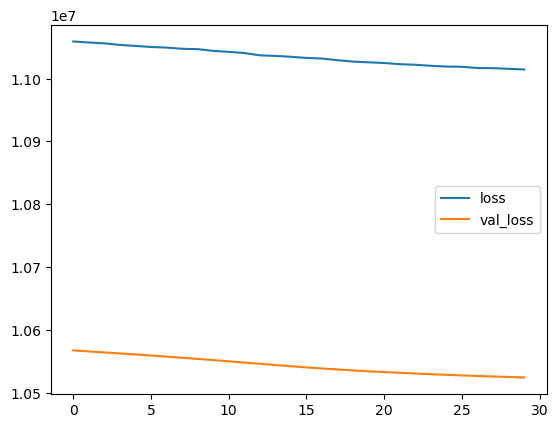

In [641]:
hisRNN[['loss','val_loss']].plot()

In [642]:
y_predRnn = modelRNN.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

<Axes: xlabel='date_time'>

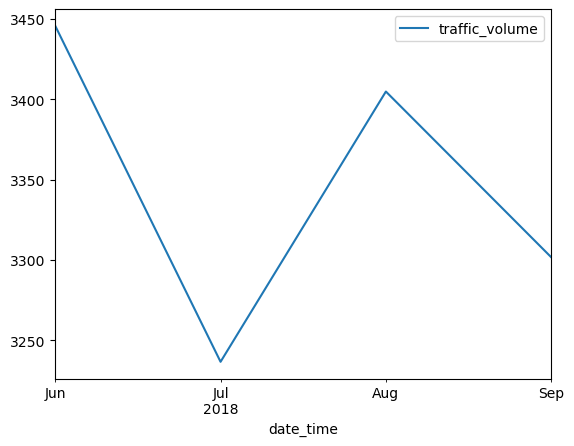

In [646]:
pd.DataFrame(y_test).plot()


In [644]:
print(mean_squared_error(y_pred,y_test))
print(rmse(y_pred,y_test))

2084463.219220649
[1539.88194899 1330.83960887 1498.98378223 1395.89757111]


## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

# 1-
drop na for the missning value and  min max scaler becouce the values are not big
# 2-
yes i do lag and mov avrige
# 3-
RNN and GRU becouse is not take time 
# 4-
if i have time i will do more epoochs for more best value
# 5-
MAE 